In [34]:
from keras.applications import inception_v3
from keras import backend as k
from keras import models, layers
import keras
keras.__version__
import numpy as np

In [10]:
# import numpy as np
# import tensorflow as tf

# x_pure = np.random.randint(-10, 100, 32)
# x_train = x_pure + np.random.randn(32) / 32
# y_train = 3 * x_pure + 2 + np.random.randn(32) / 32

# x_pure

# x_train

# y_train

# x_input = tf.placeholder(tf.float32, name='x_input')
# y_input = tf.placeholder(tf.float32, name='y_input')

# w = tf.Variable(2.0, name='weight')
# b = tf.Variable(1.0, name='baises')
# y = tf.add(tf.multiply(x_input, w), b)

# loss_op = tf.reduce_sum(tf.pow(y_input - y, 2)) / (2 * 32)
# train_op = tf.train.GradientDescentOptimizer(0.01).minimize(loss_op)
# gradients_node = tf.gradients(loss_op, w)

# sess = tf.Session()
# init = tf.global_variables_initializer()
# sess.run(init)

# for i in range(20):
#     _, gradients, loss = sess.run([train_op, gradients_node, loss_op],
#                                   feed_dict={
#                                       x_input: x_train[i],
#                                       y_input: y_train[i]
#                                   })
#     print("epoch: {} \t loss: {} \t gradients: {}".format(i, loss, gradients))
# sess.close()

In [3]:
k.set_learning_phase(0)
model = inception_v3.InceptionV3(weights='imagenet', include_top=False)

In [6]:
layer_contributions = {'mixed2': 0.2, 'mixed3': 3., 'mixed4': 2, 'mixed5': 1.5}

In [31]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

loss = k.variable(0.)
for layer_name in layer_contributions:
    coeff = layer_contributions[layer_name]
    activation = layer_dict[layer_name].output

    scaling = k.prod(k.cast(k.shape(activation), 'float32'))
    loss += coeff * k.sum(k.square(activation[:, 2:-2, 2:-2, :])) / scaling

In [35]:
dream = model.input
grads = k.gradients(loss, dream)[0]
grads /= k.maximum(k.mean(k.abs(grads)), 1e-7)

outputs = [loss, grads]
fetch_loss_and_grads = k.function([dream], outputs)

def eval_loss_and_grads(x):
    outs=fetch_loss_and_grads([x])
    loss_value=outs[0]
    grad_values=outs[1]
    return loss_value,grad_values

def gradient_ascent(x,iterations,step,max_loss=None):
    for i in range(iterations):
        loss_value,grad_values=eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('... loss value as ',i,':',loss_value)
        x+=step*grad_values
    return x

In [65]:
import scipy
from keras.preprocessing import image

def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    return scipy.ndimage.zoom(img, factors, order=1)


def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    scipy.misc.imsave(fname, pil_img)


def preprocess_image(image_path):
    # Util function to open, resize and format pictures
    # into appropriate tensors.
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(x):
    # Util function to convert a tensor into a valid image.
    if k.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [66]:
step=0.01
num_octave=3
octave_scale=1.4
iterations=20

max_loss=10.
base_image_path='F:\\study\\ml\\DataSet\\DeepDream\\1.jpg'

img=preprocess_image(base_image_path)

original_shape=img.shape[1:3]  #(294,294)
successive_shapes=[original_shape] #[(294,294)]
for i in range(1,num_octave):
    shape=tuple([int(dim/(octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
    
successive_shapes=successive_shapes[::-1]
original_img=np.copy(img)
shrunk_original_img=resize_img(img,successive_shapes[0])

for shape in successive_shapes:
    print('processing image shape',shape)
    img=resize_img(img,shape)
    img=gradient_ascent(img,
                       iterations=iterations,
                        step=step,
                        max_loss=max_loss)
    upscaled_shrunk_original_img=resize_img(shrunk_original_img,shape)
    same_size_original=resize_img(original_img,shape)
    lost_detail=same_size_original-upscaled_shrunk_original_img
    
    img+=lost_detail
    shrunk_original_img=resize_img(original_img,shape)
    save_img(img,fname='dream_at_scale_'+str(shape)+'.png')
save_img(img,fname='final_dream.png')
    

processing image shape (150, 150)
... loss value as  0 : 0.40448964
... loss value as  1 : 0.5875133
... loss value as  2 : 0.8814557
... loss value as  3 : 1.2560334
... loss value as  4 : 1.7226057
... loss value as  5 : 2.1286445
... loss value as  6 : 2.5139256
... loss value as  7 : 3.021545
... loss value as  8 : 3.4005237
... loss value as  9 : 3.8103096
... loss value as  10 : 4.23142
... loss value as  11 : 4.554991
... loss value as  12 : 5.0291243
... loss value as  13 : 5.4763293
... loss value as  14 : 5.8496523
... loss value as  15 : 6.2550726
... loss value as  16 : 6.5524836
... loss value as  17 : 7.0103936
... loss value as  18 : 7.358655
... loss value as  19 : 7.8651247
processing image shape (210, 210)


d:\programdata\anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  from ipykernel import kernelapp as app


... loss value as  0 : 1.8788238
... loss value as  1 : 3.1312554
... loss value as  2 : 4.136155
... loss value as  3 : 4.9557095
... loss value as  4 : 5.69409
... loss value as  5 : 6.4103765
... loss value as  6 : 7.076739
... loss value as  7 : 7.6957374
... loss value as  8 : 8.3209915
... loss value as  9 : 8.902132
... loss value as  10 : 9.444739
... loss value as  11 : 9.961006
processing image shape (294, 294)
... loss value as  0 : 2.2674074
... loss value as  1 : 3.4923685
... loss value as  2 : 4.489985
... loss value as  3 : 5.4106765
... loss value as  4 : 6.2722874
... loss value as  5 : 7.086671
... loss value as  6 : 7.8742757
... loss value as  7 : 8.666412
... loss value as  8 : 9.453251


In [68]:
from matplotlib import pyplot as plt

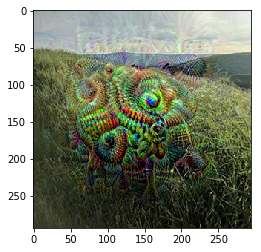

In [69]:
plt.imshow(deprocess_image(np.copy(img)))

In [45]:
img_path='F:\\study\\ml\\DataSet\\DeepDream\\1.jpg'
b=preprocess_image(img_path)

In [53]:
b.shape

(1, 294, 294, 3)

In [62]:
b.shape[1:3]

(1, 294, 294, 3)

In [59]:
c=b.shape[1:3]
c

(294, 294)

In [60]:
d=[c]
d

[(294, 294)]